# Workflow Debugging

0.8991596638655462
Compilation paths from Test Data:  {0, 1, 2, 4, 5, 7, 8}
Compilation paths from Predictions:  {0, 1, 2, 4, 5, 7, 8}
len(y_predicted) 357


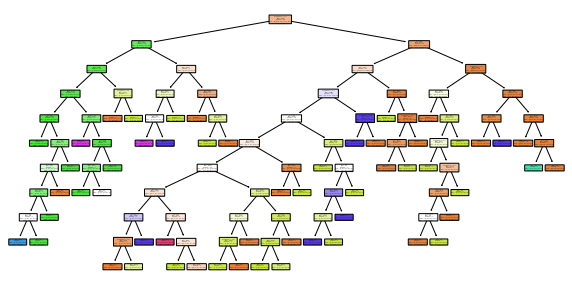

<Figure size 1224x432 with 0 Axes>

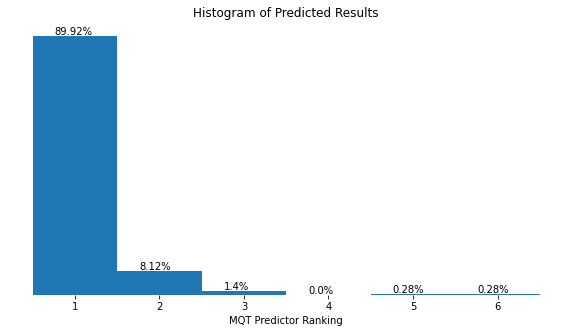

sum:  100.00000000000001


DecisionTreeClassifier(max_depth=10)

In [2]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


training_data, names_list, scores_list = Predictor.extract_training_data_from_json("big_data_new_flow_server.json", True)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#non_zero_indices = []
#for i in range(len(X[0])):
#    if sum(X[:,i]) > 0:
#        non_zero_indices.append(i)
#X = X[:, non_zero_indices]
# openqasm_gates_list = utils.get_openqasm_gates()
# res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
# res.append("num_qubits")
# features = np.sort(np.array(res))
# features = features[non_zero_indices]
# print(features)


#scaler = preprocessing.StandardScaler().fit(X)
#X = preprocessing.normalize(X, norm='l2')
#X = scaler.transform(X)

Predictor.train_decision_tree_classifier(X,y, names_list, scores_list, max_depth=10)

# Other Tree Plot Types

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(23, 5))
clf = Predictor._clf


from dtreeviz.trees import dtreeviz # remember to load the package
machines = [
        "qiskit_ibm_washington",
        "qiskit_ibm_montreal",
        "qiskit_ionq",
        "qiskit_rigetti",
        "qiskit_oqc",
        "tket_ibm_washington",
        "tket_ibm_montreal",
        "tket_ionq",
        "tket_rigetti",
        "tket_oqc",
    ]
openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")
features = np.sort(np.array(res))

X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))
(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=42)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
viz = dtreeviz(clf, 
               X_train, 
               y_train,
               target_name="target",
               feature_names=features,
               class_names=machines,
               fancy=True
)
viz.save_svg()
viz


In [ ]:
import graphviz
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X_train, y_train)
dot_data = tree.export_graphviz(clf, out_file=None, 
               feature_names=features,
               class_names=machines,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render("graphviz")

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = clf.predict(X_test)
classes = [utils.get_machines()[i] for i in set(y_test)]
res = precision_recall_fscore_support(y_test, y_pred)

with open('metric_table.csv','w') as csvfile:
    np.savetxt(csvfile, np.array([classes]),delimiter=',',fmt='%s')
    np.savetxt(csvfile, np.array(res),delimiter=',',fmt='%s')

In [ ]:
np.array([1,2,3])

In [ ]:
np.array(list(set(y_test)))